In [1]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Data processing, modeling, and model evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, plot_confusion_matrix

#Files
import h5py
import glob
import seaborn as sns

In [2]:
f=h5py.File(r'features_database_gait_one_cycles_both_legs.h5', 'r')
print(list(f.keys()))
x = f['left'][:,:,:]
print('(samples, timesteps, features)', x.shape)

['left', 'right']
(samples, timesteps, features) (76, 132, 7)


In [3]:
path = f'cut_one_gait_cycle_left'
filelist =[]
digits =[]
digits_int =[]
for file in glob.glob(f'{path}\\*.c3d',recursive = True):
    filelist.append(file[4:-4].replace("_", ""))
    digits.append(file[24:-9])

for ele in digits:
    digits_int.append(1) if ele=='degeneration' else digits_int.append(0)

In [4]:
nsamples, nx, ny = x.shape
d2_x = x.reshape((nsamples,nx*ny))

In [5]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(d2_x)
scaled_data.shape

(76, 924)

In [6]:
pca = PCA(n_components=76, svd_solver='full')
pca.fit(scaled_data)
X_pca = pca.transform(scaled_data)

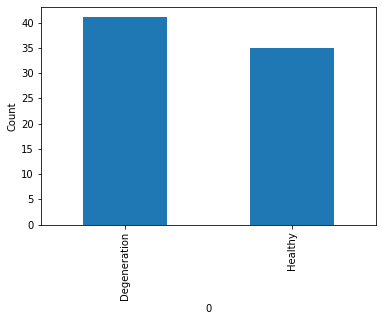

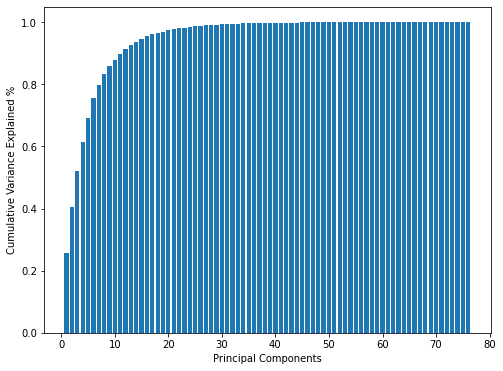

In [7]:
# Calculate cumulative explained variance across all PCs

cum_exp_var = []
var_exp = 0
for i in pca.explained_variance_ratio_:
    var_exp += i
    cum_exp_var.append(var_exp)
    
# Visualize class distribution

pd.DataFrame(digits_int).value_counts().plot(kind='bar')
plt.xticks([0,1], ['Degeneration', 'Healthy'])
plt.ylabel('Count');
    
# Plot cumulative explained variance for all PCs

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(range(1,77), cum_exp_var)
ax.set_xlabel('Principal Components')
ax.set_ylabel('Cumulative Variance Explained %');

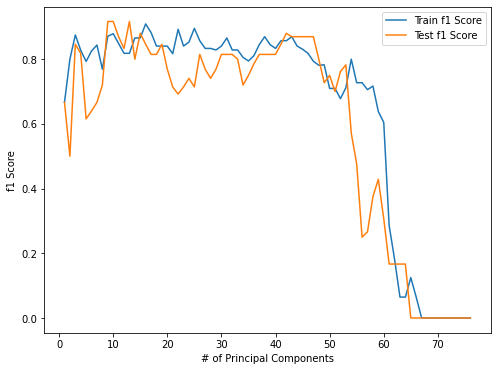

In [9]:
train_f1 = []
test_f1 = []

for i in range(76):
    
    X = X_pca[:,0:i+1]
    
    # Train-test-split
    X_train, X_test, y_train, y_test = train_test_split(X, digits_int,
                                                        test_size=0.25,
                                                        random_state=42)

    # Perform feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit k-NN classifier and make predictions
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    y_pred_train = knn.predict(X_train)
    y_pred_test = knn.predict(X_test)
    train_f1.append(f1_score(y_train, y_pred_train))
    test_f1.append(f1_score(y_test, y_pred_test))

# Plot accuracy by n_neighbors
plt.figure(figsize=(8, 6))
plt.plot(range(1,77), train_f1, label='Train f1 Score')
plt.plot(range(1,77), test_f1, label='Test f1 Score')
plt.ylabel('f1 Score')
plt.xlabel('# of Principal Components')
plt.legend()
plt.show()

In [10]:
X = X_pca[:,0:43]
    
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, digits_int,
                                                    test_size=0.25,
                                                    random_state=42)

# Perform feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit k-NN classifier and make predictions
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)
    
print(f'Train f1 Score: {f1_score(y_train, y_pred_train)}')
print(f'Test f1 Score: {f1_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

Train f1 Score: 0.8695652173913044
Test f1 Score: 0.8695652173913043
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.83      0.91      0.87        11

    accuracy                           0.84        19
   macro avg       0.85      0.83      0.83        19
weighted avg       0.84      0.84      0.84        19



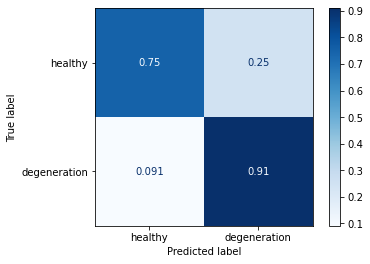

In [11]:
plot_confusion_matrix(knn, X_test, y_test, display_labels=['healthy','degeneration'],
                      normalize='true', cmap='Blues');

Text(0, 0.5, 'Fifteenth Principal Component')

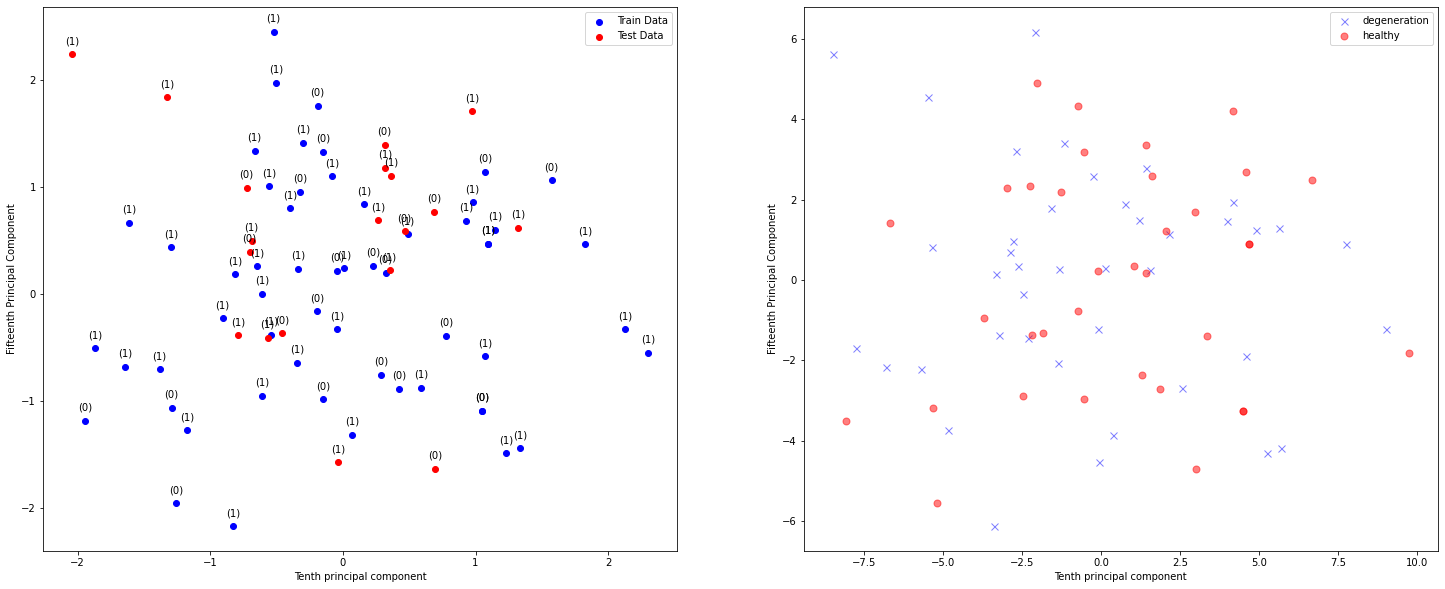

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(25,10))

#KNN and PCA

ax[0].scatter(X_train[:,10],X_train[:,15], c='blue', label='Train Data')
for x,y,z in zip(X_train[:,10],X_train[:,15], y_pred_train):
    label = f"({z})"
    ax[0].annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,10),
                 ha='center')

ax[0].scatter(X_test[:,10],X_test[:,15], c='red', label='Test Data')
for x,y,z in zip(X_test[:,10],X_test[:,15], y_pred_test):
    label = f"({z})"
    ax[0].annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,10),
                 ha='center')
    
ax[0].set_xlabel('Tenth principal component')
ax[0].set_ylabel('Fifteenth Principal Component')
ax[0].legend()

#Only PCA
ax[1].plot(X_pca[0:41,10],X_pca[0:41,15], 'x', markersize=7, color='blue', alpha=0.5, label='degeneration')
ax[1].plot(X_pca[41:76,10],X_pca[41:76,15], 'o', markersize=7, color='red', alpha=0.5, label='healthy')
ax[1].legend()
ax[1].set_xlabel('Tenth principal component')
ax[1].set_ylabel('Fifteenth Principal Component')

In [26]:
X_train

array([[-0.37327023,  0.15981435, -1.77343428, ..., -0.59512718,
        -1.58998265, -0.17786604],
       [ 0.40918193, -0.63166808, -0.83991959, ...,  0.65679349,
        -1.00291235, -0.17821549],
       [-0.46023916,  0.10049658, -0.12045761, ..., -0.93412822,
         0.28133372, -0.2734287 ],
       ...,
       [ 1.03235127, -0.7026726 , -1.27236489, ...,  0.11007973,
        -1.32478439,  1.75067931],
       [-1.01973683,  0.06337904,  0.3785762 , ..., -0.91340916,
         0.71322059, -0.48171462],
       [ 0.19677398, -1.13701919,  0.5124922 , ...,  0.34376337,
         0.66038321, -0.55861664]])